<a href="https://colab.research.google.com/github/LyMarco/Semantic-Mono-Depth/blob/master/Monodepth_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
# Look for Tesla P100-PCIE
%%shell
nvidia-smi

Mon Mar 30 20:15:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install torch
!pip3 install torchvision

In [2]:
!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git
!mv pytorch-ssim/pytorch_ssim ./

Cloning into 'pytorch-ssim'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [0]:
import torch.nn.functional as F
import os
import torch
import time
import random
from skimage import io, transform, color, data, img_as_float
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pytorch_ssim
import cv2

##Building datasets 

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# Download and unzip KITTI Dataset 2015 depth annotated
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_annotated.zip

In [0]:
##!unzip -l data_depth_annotated.zip

In [0]:
# !unzip data_depth_annotated.zip 'train/2011_09_26_drive_0001_sync/*' -d 'drive/My Drive/Depth Dataset/'
# !unzip data_depth_annotated.zip 'train/2011_09_26_drive_0009_sync/*' -d 'drive/My Drive/Depth Dataset/'
# !unzip data_depth_annotated.zip 'train/2011_09_26_drive_0084_sync/*' -d 'drive/My Drive/Depth Dataset/'
# !unzip data_depth_annotated.zip 'val/2011_09_26_drive_0005_sync/*' -d 'drive/My Drive/Depth Dataset/'
# !unzip data_depth_annotated.zip 'val/2011_09_26_drive_0095_sync/*' -d 'drive/My Drive/Depth Dataset/'

In [0]:
# Download and unzip KITTI Dataset 2015 validation set
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_selection.zip

In [86]:
# Download segment data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2020-03-31 02:23:58--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.72
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  11.5MB/s    in 29s     

2020-03-31 02:24:28 (10.7 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [0]:
!unzip -l data_semantics.zip
!unzip data_semantics.zip -d ./images
# !unzip data_semantics.zip 'training/image_2/*' -d 'drive/My Drive/Depth Dataset/segment_training'
# !unzip data_semantics.zip 'training/semantic/*' -d 'drive/My Drive/Depth Dataset/segment_training'
# !unzip data_semantics.zip 'training/semantic_rgb/*' -d 'drive/My Drive/Depth Dataset/segment_training'

# !unzip data_semantics.zip 'testing/image_2/*' -d 'drive/My Drive/Depth Dataset/segment_testing'

In [0]:
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data_downloader.zip
# !unzip raw_data_downloader.zip

In [0]:
# %%shell
# #!/bin/bash

# files=(2011_09_26_calib.zip
# 2011_09_26_drive_0001
# 2011_09_26_drive_0005
# 2011_09_26_drive_0009
# 2011_09_26_drive_0084
# 2011_09_26_drive_0095
# )

# dest='drive/My Drive/Depth Dataset/'

# for i in ${files[@]}; do
#         if [ ${i:(-3)} != "zip" ]
#         then
#                 shortname=$i'_sync.zip'
#                 fullname=$i'/'$i'_sync.zip'
#         else
#                 shortname=$i
#                 fullname=$i
#         fi
# 	echo "Downloading: "$shortname
#         wget 'https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/'$fullname
#         unzip -o $shortname -d "drive/My Drive/Depth Dataset/"
#         rm $shortname
# done

In [0]:
# # Loading in the input data
# %%shell
# source="drive/My Drive/Depth Dataset/2011_09_26/2011_09_26_drive_0001_sync/image_02/data"
# ext="../../../../input/drive_0095_"

# cd "drive/My Drive/Depth Dataset/2011_09_26/2011_09_26_drive_0095_sync/image_02/data"

# for name in *
# do
#     newname=$ext"$(echo "$name")"
#     mv "$name" "$newname"
# done

In [0]:
# # Loading in the depth maps
# %%shell
# source="drive/My Drive/Depth Dataset/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02"
# ext="../../../../../depth_maps/drive_0095_"

# cd "drive/My Drive/Depth Dataset/val/2011_09_26_drive_0095_sync/proj_depth/groundtruth/image_02"

# for name in *
# do
#     newname=$ext"$(echo "$name")"
#     mv "$name" "$newname"
# done

In [0]:
# # Split training and testing
# %%shell
# cd "drive/My Drive/Depth Dataset/depth_maps"

# for name in drive_0084*
# do
#     mv "$name" "../train_set/depth_maps/$name"
# done

In [0]:
# # Remove these entries in inputs.
# %%shell
# Dir1='drive/My Drive/Depth Dataset/train_set/input'
# Dir2='drive/My Drive/Depth Dataset/train_set/depth_maps'
# find "$Dir1/" "$Dir2/" "$Dir2/" -printf '%P\n' | sort | uniq -u

In [98]:
# Download KITTI 2015 Stereo dataset
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
# !unzip -l data_scene_flow.zip
# !unzip data_scene_flow.zip 'training/disp_occ_0/*' -d ./images/
# !unzip data_scene_flow.zip 'training/image_2/*' -d ./images/
# !unzip data_scene_flow.zip 'testing/image_2/*' -d ./images/
!unzip data_scene_flow.zip -d ./images/

Archive:  data_scene_flow.zip
   creating: ./images/training/disp_noc_1/
 extracting: ./images/training/disp_noc_1/000033_10.png  
 extracting: ./images/training/disp_noc_1/000076_10.png  
 extracting: ./images/training/disp_noc_1/000194_10.png  
 extracting: ./images/training/disp_noc_1/000137_10.png  
 extracting: ./images/training/disp_noc_1/000110_10.png  
 extracting: ./images/training/disp_noc_1/000188_10.png  
 extracting: ./images/training/disp_noc_1/000015_10.png  
 extracting: ./images/training/disp_noc_1/000155_10.png  
 extracting: ./images/training/disp_noc_1/000128_10.png  
 extracting: ./images/training/disp_noc_1/000162_10.png  
 extracting: ./images/training/disp_noc_1/000144_10.png  
 extracting: ./images/training/disp_noc_1/000052_10.png  
 extracting: ./images/training/disp_noc_1/000121_10.png  
 extracting: ./images/training/disp_noc_1/000193_10.png  
 extracting: ./images/training/disp_noc_1/000171_10.png  
 extracting: ./images/training/disp_noc_1/000101_10.png  

In [0]:
# !mv './images/training/image_2' './images/training/input'
# !mv './images/training/disp_occ_0' './images/training/depth_maps'

In [0]:
# %%shell
# Dir1='images/training/input'
# Dir2='images/training/depth_maps'
# find "$Dir1/" "$Dir2/" "$Dir2/" -printf '%P\n' | sort | uniq -u

In [101]:
%%shell

cd 'images/training/image_2'

for name in *_11.png
do
    rm $name
done

cd 'images/training/image_3'

for name in *_11.png
do
    rm $name
done

##Load Dataset

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class MapDataset(Dataset):
    """Dataset for images and depth or segmentation maps."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with folders 'input' and 'depth_maps'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.input_dir = os.path.join(self.root_dir, 'input/*')
        self.map_dir = os.path.join(self.root_dir, 'depth_maps/*')
        self.inputs = io.imread_collection(self.input_dir)
        self.maps = io.imread_collection(self.map_dir)

    def __len__(self):
      return len(self.maps)
      # return 3
      
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = {'image': self.inputs[idx], 'map': self.maps[idx]}
        if self.transform:
            item = self.transform(item)
            
            
        return item

In [0]:
class DispSegDataset(Dataset):
    """Dataset for left-right images, disparity and segmentation maps."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with folders 'input' and 'depth_maps'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.left_dir = os.path.join(self.root_dir, 'image_2/*')
        self.right_dir = os.path.join(self.root_dir, 'image_3/*')
        self.disp_left_dir = os.path.join(self.root_dir, 'disp_occ_0/*')
        self.disp_right_dir = os.path.join(self.root_dir, 'disp_occ_1/*')
        self.semantic_dir = os.path.join(self.root_dir, 'semantic/*')

        self.left = io.imread_collection(self.left_dir)
        self.right = io.imread_collection(self.right_dir)
        self.disp_left = io.imread_collection(self.disp_left_dir)
        self.disp_right = io.imread_collection(self.disp_right_dir)
        self.semantic = io.imread_collection(self.semantic_dir)

    def __len__(self):
      return len(self.left)
      # return 3
      
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = {'left': self.left[idx], 'right': self.right[idx], 
                'disp_left': self.disp_left[idx], 'disp_right': self.disp_right[idx],
                'semantic': self.semantic[idx]}
        if self.transform:
            item = self.transform(item)
            
            
        return item

In [0]:
# Data Transformations
# Rescale object repurposed from Pytorch tutorial on Datasets by Sasank Chilamkurthy
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['map']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'map': msk}

In [0]:
# Data Transformations
# Rescale object repurposed from Pytorch tutorial on Datasets by Sasank Chilamkurthy
class RescaleDispSeg(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        left, right, disp_l, disp_r, semantic = sample['left'], sample['right'], sample['disp_left'], sample['disp_right'], sample['semantic']

        h, w = left.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        left = transform.resize(left, (new_h, new_w))
        right = transform.resize(right, (new_h, new_w))
        disp_l = transform.resize(disp_l, (new_h, new_w))
        disp_r = transform.resize(disp_r, (new_h, new_w))
        semantic = transform.resize(semantic, (new_h, new_w))

        return {'left': left, 'right': right, 'disp_left':disp_l, 'disp_right':disp_r, 'semantic':semantic}

In [114]:
'''
# Load the datasest
data_path = "/content/drive/My Drive/Depth Dataset/"

#Original scale is 1242x375
scale = Rescale((256, 512))
# scale = Rescale((128, 128))
train_dir = os.path.join(data_path, 'train_set')
test_dir = os.path.join(data_path, 'test_set')

depth_train = MapDataset(train_dir, scale)
depth_test = MapDataset(test_dir, scale)
'''

'\n# Load the datasest\ndata_path = "/content/drive/My Drive/Depth Dataset/"\n\n#Original scale is 1242x375\nscale = Rescale((256, 512))\n# scale = Rescale((128, 128))\ntrain_dir = os.path.join(data_path, \'train_set\')\ntest_dir = os.path.join(data_path, \'test_set\')\n\ndepth_train = MapDataset(train_dir, scale)\ndepth_test = MapDataset(test_dir, scale)\n'

In [115]:
'''
# Test the dataset is working
print(len(depth_train))
print(len(depth_test))
i = 297
plt.figure(figsize=(32, 16))
plt.subplot(1, 2, 1), plt.imshow(depth_train[i]['image'])
plt.subplot(1, 2, 2), plt.imshow(depth_train[i]['map'], cmap='jet')
'''

"\n# Test the dataset is working\nprint(len(depth_train))\nprint(len(depth_test))\ni = 297\nplt.figure(figsize=(32, 16))\nplt.subplot(1, 2, 1), plt.imshow(depth_train[i]['image'])\nplt.subplot(1, 2, 2), plt.imshow(depth_train[i]['map'], cmap='jet')\n"

In [108]:
# Load the stereo datasest

#Original scale is 1242x375
scale = Rescale((256, 512))
depth_train_stereo = MapDataset("./images/training", scale)
# depth_test_ = MapDataset(test_dir)

ERROR! Session/line number was not unique in database. History logging moved to new session 60


200


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e43903940>,
 <matplotlib.image.AxesImage at 0x7f1e43934b70>)

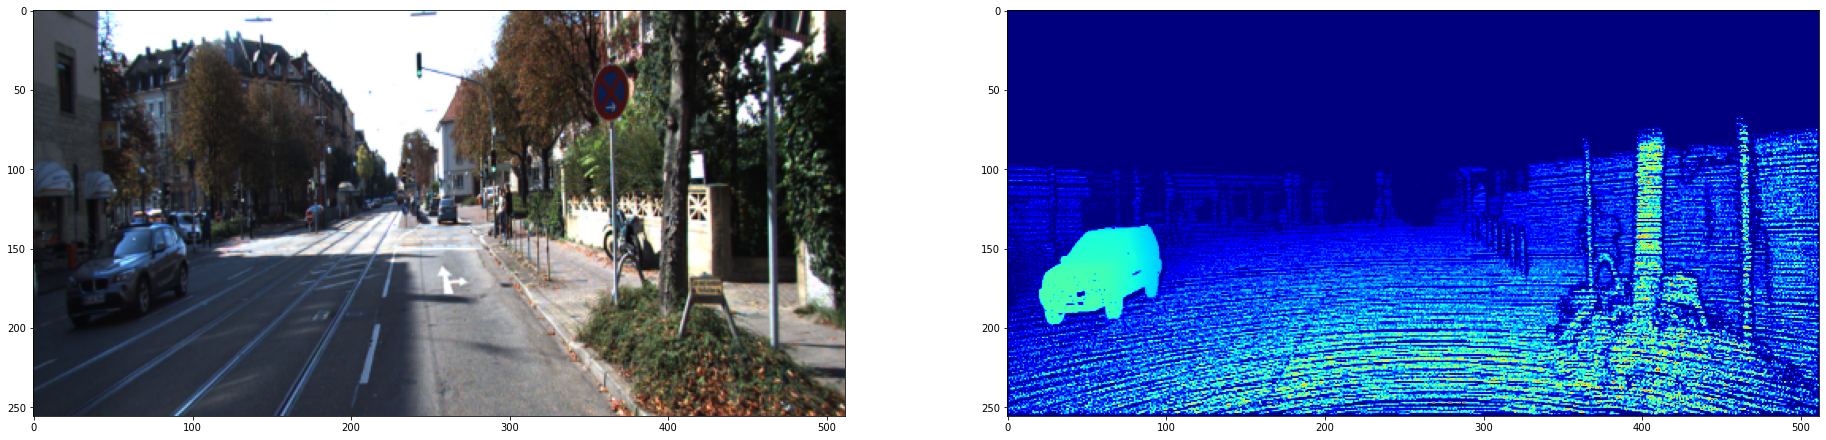

In [109]:
# Test the dataset is working
print(len(depth_train_stereo))
j = 1
plt.figure(figsize=(32, 16))
plt.subplot(1, 2, 1), plt.imshow(depth_train_stereo[j]['image'])
plt.subplot(1, 2, 2), plt.imshow(depth_train_stereo[j]['map'], cmap='jet')

In [0]:
# Load the datasest
data_path = "./images/"

#Original scale is 1242x375
scale = RescaleDispSeg((256, 512))

train_dir = os.path.join(data_path, 'training')
# test_dir = os.path.join(data_path, 'testing')

depth_train_full = DispSegDataset(train_dir, scale)

200


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1e43fa9940>,
 <matplotlib.image.AxesImage at 0x7f1f08132128>)

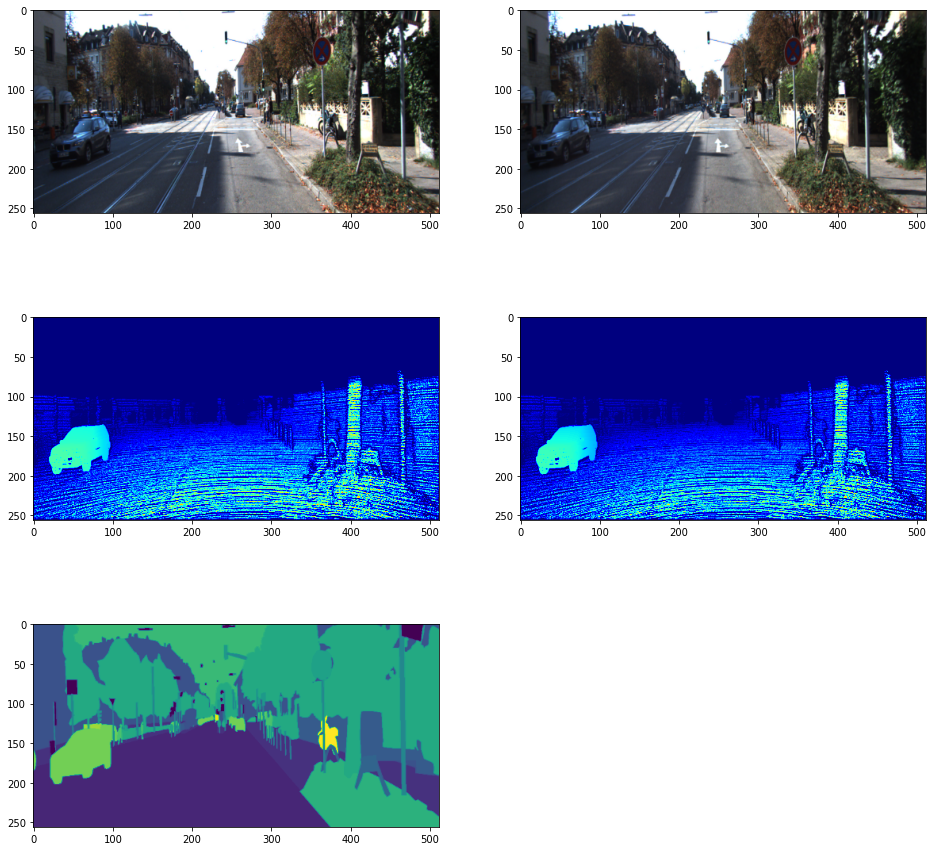

In [113]:
# Test the dataset is working
print(len(depth_train_full))
k = 1
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1), plt.imshow(depth_train_full[k]['left'])
plt.subplot(3, 2, 2), plt.imshow(depth_train_full[k]['right'])
plt.subplot(3, 2, 3), plt.imshow(depth_train_full[k]['disp_left'], cmap='jet')
plt.subplot(3, 2, 4), plt.imshow(depth_train_full[k]['disp_right'], cmap='jet')
plt.subplot(3, 2, 5), plt.imshow(depth_train_full[k]['semantic'])

#Model

In [0]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, num_filters, kernel):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, num_filters, kernel_size=kernel, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=1),
            nn.ReLU(),)
        
    def forward(self, x):
        return self.conv(x)

In [0]:
class UpConv(nn.Module):
    def __init__(self, in_channels, num_filters, kernel):
        super(UpConv, self).__init__()
        # self.conv = nn.Sequential(
        #     nn.Upsample(scale_factor=2),
        #     nn.Conv2d(in_channels, num_filters, kernel_size=kernel, padding=2) 
        #     ,)
        self.conv = nn.ConvTranspose2d(in_channels, num_filters, 
              kernel_size=kernel, stride=2, 
              padding=1, output_padding=1)
    
    def forward(self, x):
        return self.conv(x)

In [0]:
# Crops a NCHW Tensor to new H and new W
def crop_feature(tensor, new_dims):
    height, width = tensor.shape[2:]
    new_h, new_w = new_dims
    
    if (height - new_h) % 2 != 0: 
        print("Crop size failure")
        pass
    crop_h = (height - new_h) // 2
    crop_w = (width - new_w) // 2
    
    cropped_image = tensor[:, :, crop_h:-crop_h, crop_w:-crop_w]
    
    return cropped_image

In [0]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, num_filters):
        super(UNet, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.conv1 = DoubleConv(in_channels, num_filters, kernel)
        self.conv2 = DoubleConv(num_filters, num_filters*2, kernel)
        self.conv3 = DoubleConv(num_filters*2, num_filters*4, kernel)
        self.conv4 = DoubleConv(num_filters*4, num_filters*8, kernel)

        self.acrossconv = DoubleConv(num_filters*8, num_filters*16, kernel)
        
        self.upconv1 = UpConv(num_filters*16, num_filters*8, kernel)
        self.conv5 = DoubleConv(num_filters*16, num_filters*8, kernel)
        self.upconv2 = UpConv(num_filters*8, num_filters*4, kernel)
        self.conv6 = DoubleConv(num_filters*8, num_filters*4, kernel)
        self.upconv3 = UpConv(num_filters*4, num_filters*2, kernel)
        self.conv7 = DoubleConv(num_filters*4, num_filters*2, kernel)
        self.upconv4 = UpConv(num_filters*2, num_filters, kernel)
        self.conv8 = DoubleConv(num_filters*2, num_filters, kernel)
      
        self.finalconv = nn.Sequential(
            nn.Conv2d(num_filters, out_channels, kernel_size=kernel, padding=1),
            nn.Sigmoid(),)
        
    def forward(self, x):
        self.out1 = self.conv1(x)
        self.out1max = self.maxpool(self.out1)
        self.out2 = self.conv2(self.out1max)
        self.out2max = self.maxpool(self.out2)
        self.out3 = self.conv3(self.out2max)
        self.out3max = self.maxpool(self.out3)
        self.out4 = self.conv4(self.out3max)
        self.out4max = self.maxpool(self.out4)

        self.rf = self.acrossconv(self.out4max)

        self.up1 = self.upconv1(self.rf)
        self.out5 = self.conv5(torch.cat((self.up1, self.out4), 1))
        self.up2 = self.upconv2(self.out5)
        self.out6 = self.conv6(torch.cat((self.up2, self.out3), 1))
        self.up3 = self.upconv3(self.out6)
        self.out7 = self.conv7(torch.cat((self.up3, self.out2), 1))
        self.up4 = self.upconv4(self.out7)
        self.out8 = self.conv8(torch.cat((self.up4, self.out1), 1))
        
        self.out_final = self.finalconv(self.out8)
          
        return self.out_final


In [0]:
class UNet_Double(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, num_filters, num_seg_classes):
        super(UNet_Double, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.conv1 = DoubleConv(in_channels, num_filters, kernel)
        self.conv2 = DoubleConv(num_filters, num_filters*2, kernel)
        self.conv3 = DoubleConv(num_filters*2, num_filters*4, kernel)

        self.acrossconv = DoubleConv(num_filters*4, num_filters*8, kernel)
        
        self.upconv1 = UpConv(num_filters*8, num_filters*4, kernel)
        self.conv5 = DoubleConv(num_filters*8, num_filters*4, kernel)
        self.upconv2 = UpConv(num_filters*4, num_filters*2, kernel)
        self.conv6 = DoubleConv(num_filters*4, num_filters*2, kernel)
        self.upconv3 = UpConv(num_filters*2, num_filters, kernel)
        self.conv7 = DoubleConv(num_filters*2, num_filters, kernel)
      
        self.disp = nn.Sequential(
            nn.Conv2d(num_filters, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),)

        self.seg = nn.Conv2d(num_filters, num_seg_classes, kernel_size=kernel, padding=1)
        
    def forward(self, x):
        # Encoder
        self.out1 = self.conv1(x)
        self.out1max = self.maxpool(self.out1)
        self.out2 = self.conv2(self.out1max)
        self.out2max = self.maxpool(self.out2)
        self.out3 = self.conv3(self.out2max)
        self.out3max = self.maxpool(self.out3)

        self.rf = self.acrossconv(self.out3max)

        # Disparity decoder
        self.up1 = self.upconv1(self.rf)
        self.out5 = self.conv5(torch.cat((self.up1, self.out3), 1))
        self.up2 = self.upconv2(self.out5)
        self.out6 = self.conv6(torch.cat((self.up2, self.out2), 1))
        self.up3 = self.upconv3(self.out6)
        self.out7 = self.conv7(torch.cat((self.up3, self.out1), 1))
        self.out_disp = self.disp(self.out7)

        # Segmentation decoder
        self.up1seg = self.upconv1(self.rf)
        self.out5seg = self.conv5(torch.cat((self.up1seg, self.out3), 1))
        self.up2seg = self.upconv2(self.out5)
        self.out6seg = self.conv6(torch.cat((self.up2seg, self.out2), 1))
        self.up3seg = self.upconv3(self.out6)
        self.out7seg = self.conv7(torch.cat((self.up3seg, self.out1), 1))
        self.out_seg = self.seg(self.out7seg)
          
        return self.out_disp, self.out_seg


# Training

In [0]:
a_d = 1.0
a_s = 0.1
gamma = 0.85

def SSIM_loss(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 **2 

    mu_x = F.avg_pool2d(x, 3, 1, 1)
    mu_y = F.avg_pool2d(y, 3, 1, 1)

    sigma_x  = F.avg_pool2d(x ** 2, 3, 1, 1) - mu_x ** 2
    sigma_y  = F.avg_pool2d(y ** 2, 3, 1, 1) - mu_y ** 2
    sigma_xy = F.avg_pool2d(x * y , 3, 1, 1) - mu_x * mu_y

    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    SSIM = SSIM_n / SSIM_d

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def depth_loss(out, target):
    # SSIM = pytorch_ssim.SSIM(window_size=11)
    L1 = torch.nn.L1Loss(size_average=False, reduce=False)
    sim = torch.mean(1 - SSIM_loss(out, target))
    
    print(sim.shape)
    pixel_loss = L1(out, target)
    
    print(pixel_loss.shape)
    return torch.sum(gamma * sim + (1- gamma) * pixel_loss)

def sem_loss(out, target):
    CE = nn.BCELoss()
    return CE(out, target) 

def total_loss(out, target):
    return a_d * depth_loss(out, target) + a_s * sem_loss(out, target)

In [0]:
def validation(model, criterion, testdata, device):
    losses = []

    for i_batch, test_sample in enumerate(testdata):
        images = test_sample['image']
        masks = test_sample['map']
        
        reshaped_images = np.transpose(images, (0, 3, 1, 2))
        reshaped_masks = np.reshape(masks, (-1, 1, 256, 512))
    
        reshaped_images = reshaped_images.to(device)
        reshaped_masks = reshaped_masks.to(device)

        output = model(reshaped_images)

        loss = criterion(output, reshaped_masks)
        losses.append(loss.data.item())

    val_loss = np.mean(losses)
    return val_loss

In [0]:
'''
# Main training loop

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args):
    torch.set_num_threads(5)

    np.random.seed(args.seed)

    # DATALOADERS
    trainloader = torch.utils.data.DataLoader(args.train_data, batch_size=args.batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(args.test_data, batch_size=args.batch_size, shuffle=True)
    
    # MODEL
    num_in_channels = 1 if not args.downsize_input else 3
    if args.model == "DOUBLE":
        model = UNet_Double(in_channels=num_in_channels, out_channels=1,
                 kernel=args.kernel, num_filters=args.num_filters, num_seg_classes=6)
    elif args.model == "UNET":
        model = UNet(in_channels=num_in_channels, out_channels=1,
                 kernel=args.kernel, num_filters=args.num_filters)
    else:
        model = CNN(in_channels=num_in_channels, out_channels=1,
                 kernel=args.kernel, num_filters=args.num_filters)


    # LOSS FUNCTION
    if args.loss == "DEPTH-SEG":
        criterion = total_loss
    elif args.loss == "DEPTH":
        criterion = depth_loss
    elif args.loss == "SEG":
        criterion = sem_loss
    elif args.loss == "BCE":
        criterion = nn.BCELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=args.learn_rate)

    # Train the model
    print("Beginning training ...")
    if args.gpu and torch.cuda.is_available(): 
        device = torch.device("cuda")
        model.cuda()
    else:
        device = torch.device("cpu")
      
    start = time.time()

    train_losses = []
    val_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # print(epoch)
        # Train the Model
        model.train() # Change model to 'train' mode
        model.double()
        
        losses = []

        # Forward + Backward + Optimize
        # try:
        for i_batch, sample_batched in enumerate(trainloader):
            # print(i_batch)
            optimizer.zero_grad()

            images = sample_batched['image']
            masks = sample_batched['map']
            reshaped_images = np.transpose(images, (0, 3, 1, 2))
            reshaped_masks = np.reshape(masks, (-1, 1, 256, 512))
            
            reshaped_images = reshaped_images.to(device)
            reshaped_masks = reshaped_masks.to(device)

            model_output = model(reshaped_images)
            # print(model_output.shape)
            
            loss = criterion(model_output, reshaped_masks)
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())
        else:
            avg_loss = np.mean(losses)
            train_losses.append(avg_loss)
            time_elapsed = time.time() - start
            
            model.eval()
            val_loss = validation(model, criterion, testloader, device)
            # val_loss = 0
            
            val_losses.append(val_loss)
            print('Epoch [%d/%d], Loss: %.4f, Val Loss: %.4f,  Time (s): %d' % (
                epoch+1, args.epochs, avg_loss, val_loss, time_elapsed))
            
            
    # Plot training curve
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, "b-", label="Training")
    plt.plot(val_losses, "r-", label="Validation")
    plt.legend()
    plt.title("UNet Performance")
    plt.xlabel("Epochs")
    return model
'''
# Main training loop

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args):
    torch.set_num_threads(5)

    np.random.seed(args.seed)

    # DATALOADERS
    trainloader = torch.utils.data.DataLoader(args.train_data, batch_size=args.batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(args.test_data, batch_size=args.batch_size, shuffle=True)
    
    # MODEL
    num_in_channels = 1 if not args.downsize_input else 3
    model = UNet_Double(in_channels=num_in_channels, out_channels=1,
              kernel=args.kernel, num_filters=args.num_filters, num_seg_classes=6)


    # LOSS FUNCTION
    if args.loss == "DEPTH-SEG":
        criterion = total_loss
    elif args.loss == "DEPTH":
        criterion = depth_loss
    elif args.loss == "SEG":
        criterion = sem_loss
    elif args.loss == "BCE":
        criterion = nn.BCELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=args.learn_rate)

    # Train the model
    print("Beginning training ...")
    if args.gpu and torch.cuda.is_available(): 
        device = torch.device("cuda")
        model.cuda()
    else:
        device = torch.device("cpu")
      
    start = time.time()

    train_losses = []
    val_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        model.train() # Change model to 'train' mode
        model.double()
        
        losses = []

        # Forward + Backward + Optimize
        # try:
        for i_batch, sample_batched in enumerate(trainloader):
            # print(i_batch)
            optimizer.zero_grad()

            images = sample_batched['image']
            masks = sample_batched['map']
            reshaped_images = np.transpose(images, (0, 3, 1, 2))
            reshaped_masks = np.reshape(masks, (-1, 1, 256, 512))
            
            reshaped_images = reshaped_images.to(device)
            reshaped_masks = reshaped_masks.to(device)

            model_output = model(reshaped_images)
            # print(model_output.shape)
            
            loss = criterion(model_output, reshaped_masks)
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())
        else:
            avg_loss = np.mean(losses)
            train_losses.append(avg_loss)
            time_elapsed = time.time() - start
            
            model.eval()
            val_loss = validation(model, criterion, testloader, device)
            # val_loss = 0
            
            val_losses.append(val_loss)
            print('Epoch [%d/%d], Loss: %.4f, Val Loss: %.4f,  Time (s): %d' % (
                epoch+1, args.epochs, avg_loss, val_loss, time_elapsed))
            
            
    # Plot training curve
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, "b-", label="Training")
    plt.plot(val_losses, "r-", label="Validation")
    plt.legend()
    plt.title("UNet Performance")
    plt.xlabel("Epochs")
    return model

In [0]:
# Arguments for training
args = AttrDict()
args_dict = {
              'gpu':True, 
              'loss':"DEPTH", 
              'model':"UNET",
              'kernel':3,
              'num_filters':4, 
              'learn_rate':0.0003, 
              'batch_size':2, 
              'epochs':2, 
              'seed':0,
              'downsize_input':True,
              'train_data':depth_train,
              'test_data':depth_test,
}
args.update(args_dict)
unet_depth = train(args)
# unet_double = train(args)

## Custom training loop

In [0]:
# Debug training loop

def debug_train(model, device, criterion, optimizer, epochs, prev_epochs, graph):
    
    # Train the model
    print("Beginning training ...")

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Train the Model
        model.train() # Change model to 'train' mode
        model.double()

        start = time.time()

        # Forward + Backward + Optimize
        losses = []

        for i_batch, sample_batched in enumerate(trainloader):
            optimizer.zero_grad()
            
            images = sample_batched['image']
            masks = sample_batched['map']

            reshaped_images = np.transpose(images, (0, 3, 1, 2))
            reshaped_masks = np.reshape(masks, (-1, 1, 256, 512))
        
            reshaped_images = reshaped_images.to(device)
            reshaped_masks = reshaped_masks.to(device)

            model_output = model(reshaped_images) 
            
            loss = criterion(model_output, reshaped_masks)

            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())
            
        avg_loss = np.mean(losses)
        model.eval()
        val_loss = validation(model, criterion, testloader, device)
        # val_loss = 0

        train_losses.append(avg_loss)
        val_losses.append(val_loss)

        # if epoch == epochs-1:
        print('Epoch [%d/%d], Loss: %.4f, Val Loss: %.4f, Time: %ds' % (
              epoch+1+prev_epochs, epochs+prev_epochs, avg_loss, val_loss, time.time() - start))

    # Plot training curve
    plt.figure(figsize=(10, 8))
    plt.plot(train_losses, "b-", label="Training")
    plt.plot(val_losses, "r-", label="Validation")
    plt.legend()
    plt.title(graph)
    plt.xlabel("Epochs")

    print('Trained unet on [%d] total epochs thus far' % (epochs + prev_epochs))

    return model

In [0]:
args_dict = {
              'gpu':True,  
              'kernel':3,
              'num_filters':8, 
              'learn_rate':0.0003, 
              'batch_size':2, 
              'seed':0,
              'train_data':depth_train,
              'test_data':depth_test,
}

torch.set_num_threads(5)
np.random.seed(args_dict['seed'])

trainloader = torch.utils.data.DataLoader(args_dict['train_data'], batch_size=args_dict['batch_size'], shuffle=True)
testloader = torch.utils.data.DataLoader(args_dict['test_data'], batch_size=args_dict['batch_size'], shuffle=True)
    
# MODEL
# unet = UNet(in_channels=3, out_channels=1,
#               kernel=args_dict['kernel'], num_filters=args_dict['num_filters'])
# unet_depth = UNet(in_channels=3, out_channels=1,
#               kernel=args_dict['kernel'], num_filters=args_dict['num_filters'])

criterion = nn.BCELoss()
criterion_depth = depth_loss

optimizer = torch.optim.Adam(unet.parameters(), lr=args_dict['learn_rate'])

device = torch.device("cuda")
# unet.cuda();
# unet_depth.cuda();

In [0]:
unet = UNet(in_channels=3, out_channels=1,
              kernel=args_dict['kernel'], num_filters=args_dict['num_filters'])
unet.cuda();

Beginning training ...
Epoch [1/20], Loss: 0.1104, Val Loss: 0.0456, Time: 193s
Epoch [2/20], Loss: 0.0523, Val Loss: 0.0450, Time: 194s
Epoch [3/20], Loss: 0.0521, Val Loss: 0.0448, Time: 194s
Epoch [4/20], Loss: 0.0519, Val Loss: 0.0448, Time: 193s
Epoch [5/20], Loss: 0.0518, Val Loss: 0.0447, Time: 192s
Epoch [6/20], Loss: 0.0518, Val Loss: 0.0456, Time: 191s
Epoch [7/20], Loss: 0.0517, Val Loss: 0.0448, Time: 191s
Epoch [8/20], Loss: 0.0516, Val Loss: 0.0452, Time: 190s
Epoch [9/20], Loss: 0.0514, Val Loss: 0.0443, Time: 190s
Epoch [10/20], Loss: 0.0513, Val Loss: 0.0444, Time: 190s
Epoch [11/20], Loss: 0.0512, Val Loss: 0.0444, Time: 190s
Epoch [12/20], Loss: 0.0510, Val Loss: 0.0441, Time: 191s
Epoch [13/20], Loss: 0.0508, Val Loss: 0.0441, Time: 190s
Epoch [14/20], Loss: 0.0505, Val Loss: 0.0440, Time: 190s
Epoch [15/20], Loss: 0.0503, Val Loss: 0.0440, Time: 189s
Epoch [16/20], Loss: 0.0501, Val Loss: 0.0441, Time: 189s
Epoch [17/20], Loss: 0.0500, Val Loss: 0.0443, Time: 189s


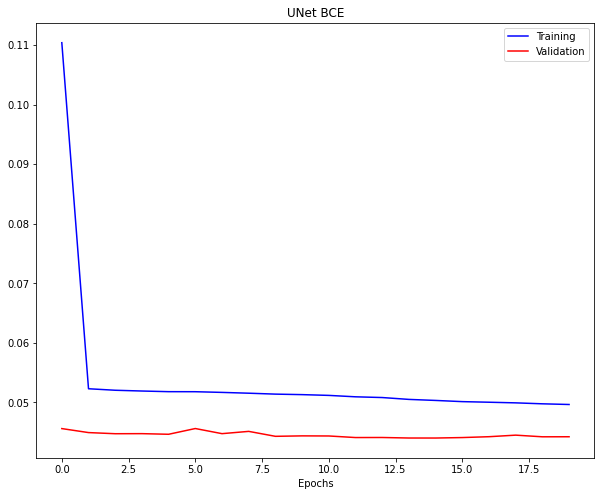

In [60]:
unet = debug_train(unet, device, criterion, optimizer, 5, 0, "UNet BCE")

In [0]:
unet_depth = UNet(in_channels=3, out_channels=1,
              kernel=args_dict['kernel'], num_filters=args_dict['num_filters'])
unet_depth.cuda();

Beginning training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [1/3], Loss: 132924.3479, Val Loss: 132864.5452, Time: 196s
Epoch [2/3], Loss: 132924.3479, Val Loss: 132864.5452, Time: 191s
Epoch [3/3], Loss: 132924.3479, Val Loss: 132864.5452, Time: 190s
Trained unet on [3] total epochs thus far


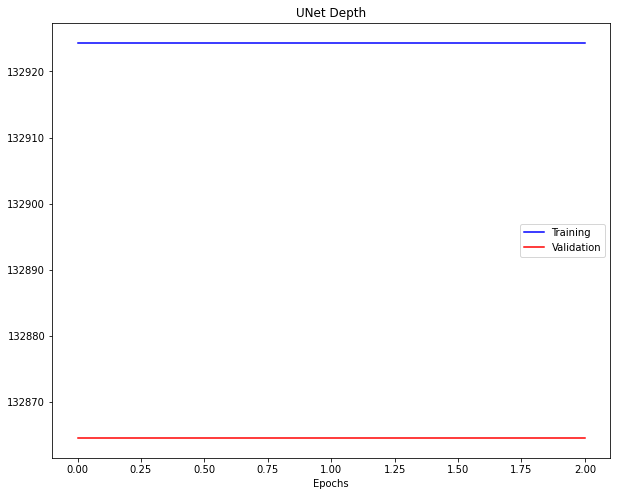

In [84]:
unet_depth = debug_train(unet_depth, device, criterion_depth, optimizer, 3, 0, "UNet Depth")

#Evaluation

In [0]:
# Display a model's outputs against a dataset
def display(i, data, network):
    sample = data[i]
    device = torch.device("cuda")
    plt.subplot(1, 3, 1), plt.imshow(sample['image'])
    item = sample['image']
    re_item = np.transpose(item, (2, 0, 1))
    re_item = np.reshape(re_item, (-1, 3, 256, 512))
    re_item = torch.from_numpy(re_item).to(device)
    model_item = network(re_item).cpu().detach().numpy()

    result = model_item[0, 0]

    plt.subplot(1, 3, 2), plt.imshow(sample['map'], cmap='jet')
    plt.subplot(1, 3, 3), plt.imshow(result, cmap='jet')

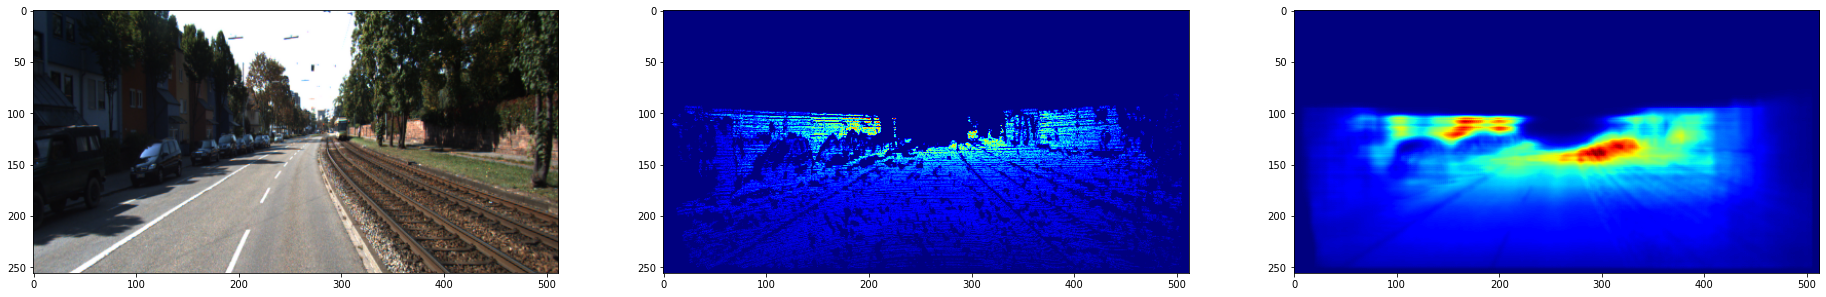

In [67]:
plt.figure(figsize=(32, 22))
display(5, depth_train, unet)

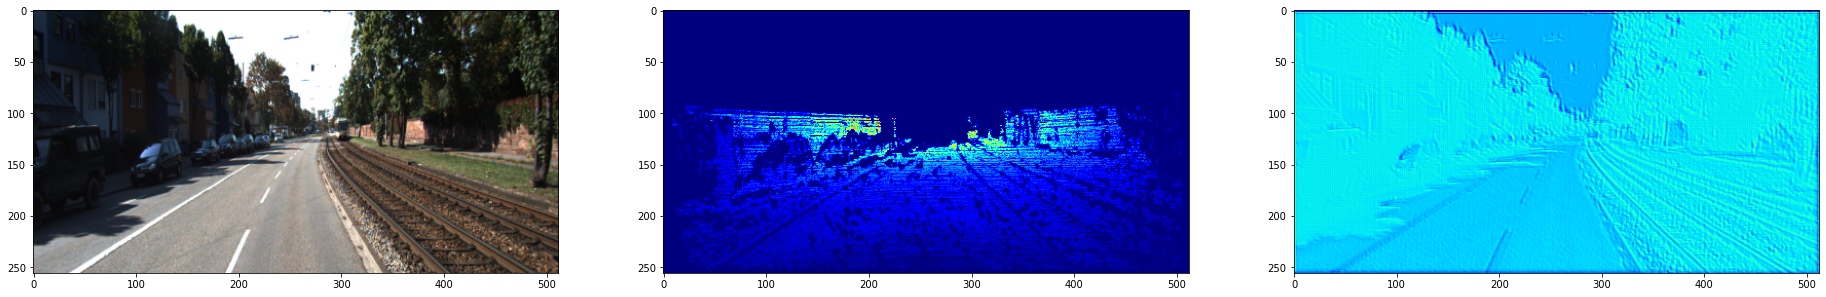

In [78]:
plt.figure(figsize=(32, 22))
display(5, depth_train, unet_depth)

In [68]:
torch.save(unet, 'unet_base_1.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DoubleConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UpConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
